In [1]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow
import sys

print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]
pandas:  1.2.4
numpy:  1.20.2
seaborn:  0.11.1
matplotlib:  3.3.4
sklearn:  0.24.2
Keras:  2.5.0
Tensorflow:  2.5.0


In [2]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(
    x_train, (len(x_train), 28, 28,
              1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(
    x_test, (len(x_test), 28, 28,
             1))  # adapt this if using `channels_first` image data format

In [4]:
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K

# Convolutional Autoencoder
logfilename = "ConvolutionalAutoencoder"

input_img = Input(
    shape=(28, 28,
           1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [5]:
autoencoder.compile(optimizer=tf.keras.optimizers.RMSprop(),
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [6]:
batch_size = 32
epochs = 20

history = autoencoder.fit(
    x_train,
    x_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    shuffle=True,
    validation_data=(x_test, x_test),
    #     callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))]
)

Epoch 1/20
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0339 - mae: 0.0824 - accuracy: 0.8000 - val_loss: 0.0222 - val_mae: 0.0597 - val_accuracy: 0.8053
Epoch 2/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0212 - mae: 0.0566 - accuracy: 0.8076 - val_loss: 0.0178 - val_mae: 0.0508 - val_accuracy: 0.8095
Epoch 3/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0180 - mae: 0.0504 - accuracy: 0.8095 - val_loss: 0.0182 - val_mae: 0.0504 - val_accuracy: 0.8057
Epoch 4/20
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0165 - mae: 0.0472 - accuracy: 0.8105 - val_loss: 0.0165 - val_mae: 0.0483 - val_accuracy: 0.8084
Epoch 5/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0155 - mae: 0.0452 - accuracy: 0.8110 - val_loss: 0.0147 - val_mae: 0.0438 - val_accuracy: 0.8089
Epoch 6/20
1875/1875 [==============================] - 35s 18ms/step - loss: 0.0147 - mae: 0.0437 - accuracy:

In [7]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 5ms/step - loss: 0.0106 - mae: 0.0351 - accuracy: 0.8127
Test loss: 0.010614821687340736
Test accuracy: 0.035129595547914505


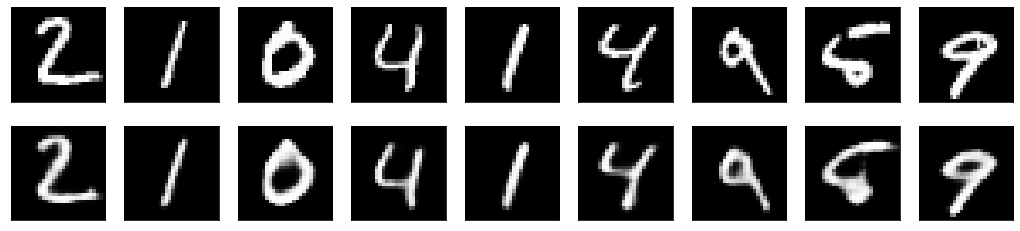

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

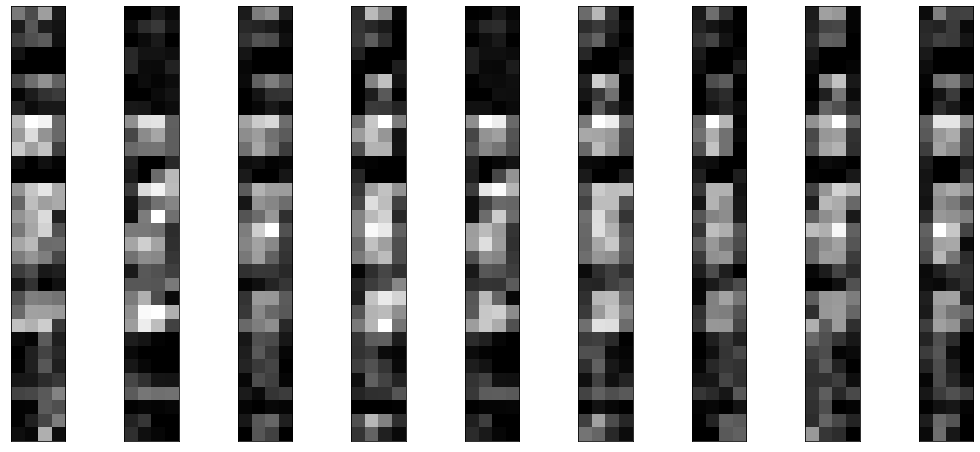

In [9]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()